# Data Downtime Challenge | Exercise 3

## 0. Setup

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
import sqlite3

conn = sqlite3.connect('Ex3.db')
c = conn.cursor()

## 1. Introduction

In the last exercise, we looked at incidents spanning multiple tables in a database. Yet, we've still only been looking at _individual_ metrics like the row count, rate of null values, and so on. In practice, many genuine data downtime incidents involve _conjunctions_ of events across multiple upstream and downstream tables. In this exercise, we practice crafting single queries that can handle such conjunctive events.

## 2. Data

In this exercise, we'll continue to use the `EXOPLANETS`, `HABITABLES`, and `EXOPLANETS_SCHEMA` tables. There is also a `HABITABLES_SCHEMA` table, and all four contain additional entries beyond those in exercise 2.

In [4]:
# show all tables in DB
pd.read_sql_query("""
SELECT 
    name
FROM 
    sqlite_master 
WHERE 
    type ='table' AND 
    name NOT LIKE 'sqlite_%';
""",
                 conn)

,name
0,EXOPLANETS
1,EXOPLANETS_SCHEMA
2,HABITABLES


## 3. Exercise: Pillars of Data Observability in Conjunction

Why care about conjunctions of events, when individual events provide all the information you need? One important factor is **noise** -- looking at simultaneous events reduces the total number of events you're worried about, and makes it more lilely that the issues are genuine. Another factor is **causality** -- given an issue in some table, looking at simultaneous events in upstream tables might help you determine the root cause.

Take the past exercise as an example -- we saw that the `habitability` field had anomalous rates of zeroed values:

In [19]:
from datetime import datetime, timedelta
all_days = []
date = datetime(2020, 1, 1)
for _ in range(350):
    all_days.append(date.strftime("%Y-%m-%d"))
    date += timedelta(days=1)
all_days = pd.Index(all_days)

In [20]:
zero_rate_query = """
SELECT
    DATE_ADDED,
    CAST(SUM(CASE WHEN HABITABILITY IS 0 THEN 1 ELSE 0 END) AS FLOAT) / COUNT(*) AS ZERO_RATE
FROM
    HABITABLES
GROUP BY
    DATE_ADDED
"""

In [21]:
anoms_query = """
WITH HABITABILITY_ZERO_RATE AS(
SELECT
    DATE_ADDED,
    CAST(SUM(CASE WHEN HABITABILITY IS 0 THEN 1 ELSE 0 END) AS FLOAT) / COUNT(*) AS ZERO_RATE
FROM
    HABITABLES
GROUP BY
    DATE_ADDED
)

SELECT
    DATE_ADDED
FROM
    HABITABILITY_ZERO_RATE
WHERE
    ZERO_RATE IS NOT NULL AND
    ZERO_RATE > 0.3
"""

In [22]:
habitability_zero_rate = pd.read_sql_query(zero_rate_query, conn)
habitability_zero_rate = habitability_zero_rate \
    .rename(columns={clmn: clmn.lower() for clmn in habitability_zero_rate.columns})
habitability_zero_rate = habitability_zero_rate.set_index("date_added")
habitability_zero_rate = habitability_zero_rate.reindex(all_days)

habitability_zero_rate_alerts = pd.read_sql_query(anoms_query, conn)
habitability_zero_rate_alerts = habitability_zero_rate_alerts \
    .rename(columns={clmn: clmn.lower() for clmn in habitability_zero_rate_alerts.columns})

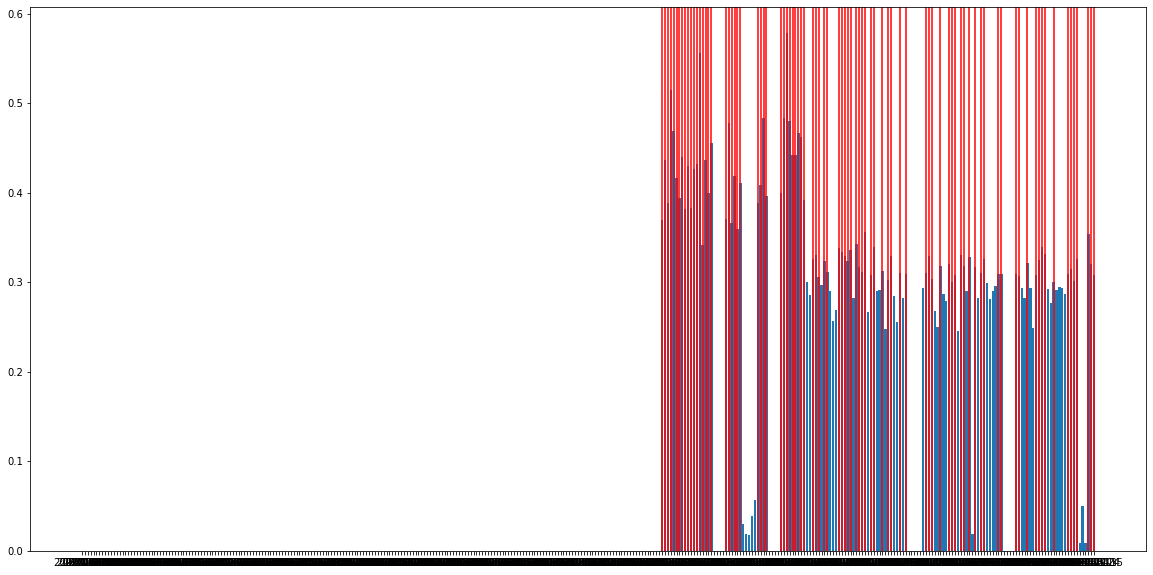

In [23]:
plt.figure(figsize=(20, 10))
plt.bar(all_days, height=habitability_zero_rate["zero_rate"])
for alert in habitability_zero_rate_alerts["date_added"]: plt.axvline(x = alert, color = 'r')
plt.show()

In [24]:
habitability_zero_rate_alerts["date_added"]

0     2020-07-19
1     2020-07-20
2     2020-07-21
3     2020-07-22
4     2020-07-23
         ...    
83    2020-12-08
84    2020-12-09
85    2020-12-13
86    2020-12-14
87    2020-12-15
Name: date_added, Length: 88, dtype: object

Great, but too noisy! We wouldn't want a notification for every red line on the above graph. Looking for other (upstream) events can not only prune our alerts, but also help us identify the issue's cause.

See if you can join the timestamps from `habitability_zero_rate_alerts` with timestamps identifying a `schema_change`.

- *Hint*: try querying the `EXOPLANETS_SCHEMA` table using the same approach from Exercise 2.

In [25]:
# YOUR CODE HERE
SQL = """
WITH HABITABILITY_ZERO_RATE AS(
SELECT
    DATE_ADDED AS date,
    CAST(SUM(CASE WHEN HABITABILITY IS 0 THEN 1 ELSE 0 END) AS FLOAT) / COUNT(*) AS ZERO_RATE
FROM
    HABITABLES
GROUP BY
    DATE_ADDED
),

SCHEMA_CHANGES AS(
    SELECT
        date,
        schema AS new_schema,
        LAG(schema) OVER(ORDER BY date) AS past_schema
    FROM
        EXOPLANETS_SCHEMA
),

SCHEMA_ALERTS AS(
SELECT
    *
FROM
    SCHEMA_CHANGES
WHERE
    new_schema != past_schema
ORDER BY
    date ASC
)

SELECT
    DATE
FROM
    HABITABILITY_ZERO_RATE
JOIN
SCHEMA_ALERTS USING (date)
WHERE
    ZERO_RATE IS NOT NULL AND
    ZERO_RATE > 0.3
"""
# END YOUR CODE

In [26]:
joint_anoms = pd.read_sql_query(SQL, conn)
joint_anoms = joint_anoms \
    .rename(columns={clmn: clmn.lower() for clmn in joint_anoms.columns})
joint_anoms

,date
0,2020-07-19


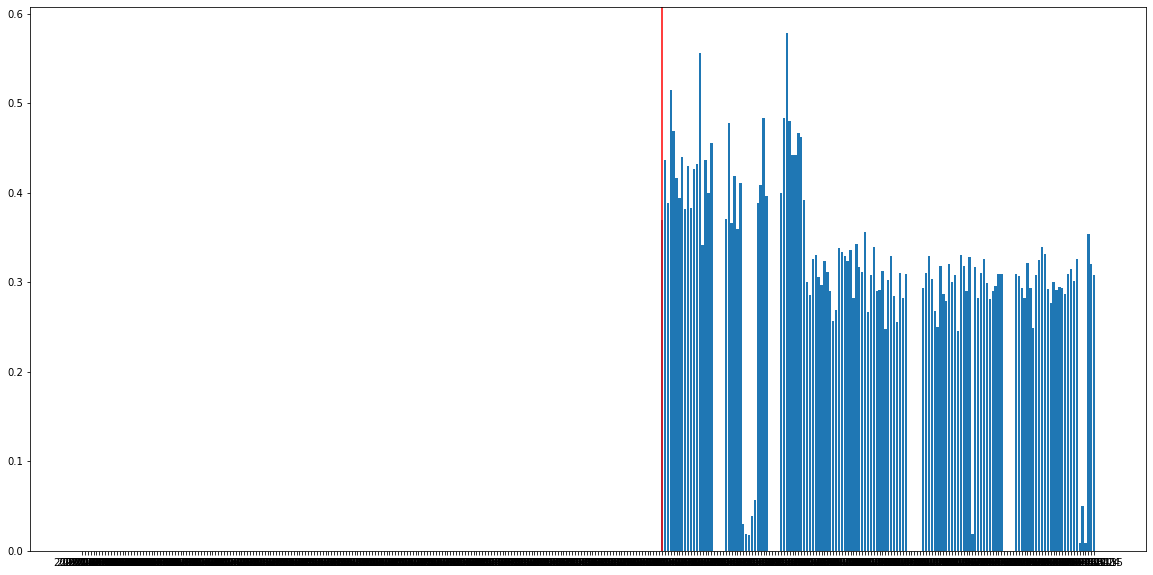

In [27]:
plt.figure(figsize=(20, 10))
plt.bar(all_days, height=habitability_zero_rate["zero_rate"])
for alert in joint_anoms["date"]: plt.axvline(x = alert, color = 'r')
plt.show()

In [28]:
habitability_zero_rate["zero_rate"]

2020-01-01    0.000000
2020-01-02    0.000000
2020-01-03    0.000000
2020-01-04    0.000000
2020-01-05    0.000000
                ...   
2020-12-11    0.049587
2020-12-12    0.008772
2020-12-13    0.353333
2020-12-14    0.320000
2020-12-15    0.307692
Name: zero_rate, Length: 350, dtype: float64

You should see a single reported date, `2020-07-19`. Not only have we reduced the number of reports, but we potentially learn something -- that the schema change in `EXOPLANETS` _caused_ the zero rate in `HABITABLES` to spike. By combining data observability pillars, we're one step closer to resolving the problem!

## 4. Exercise: Diagnosing Another Distribution Issue

Here's another quick mystery. It looks like the `HABITABLES` table returns to normal after a while, if we only look at zero rates. But probing into the **volume** of the table reveals something odd:

In [29]:
SQL = """
SELECT
    DATE_ADDED,
    COUNT(*) AS ROWS_ADDED
FROM
    HABITABLES
GROUP BY
    DATE_ADDED
"""

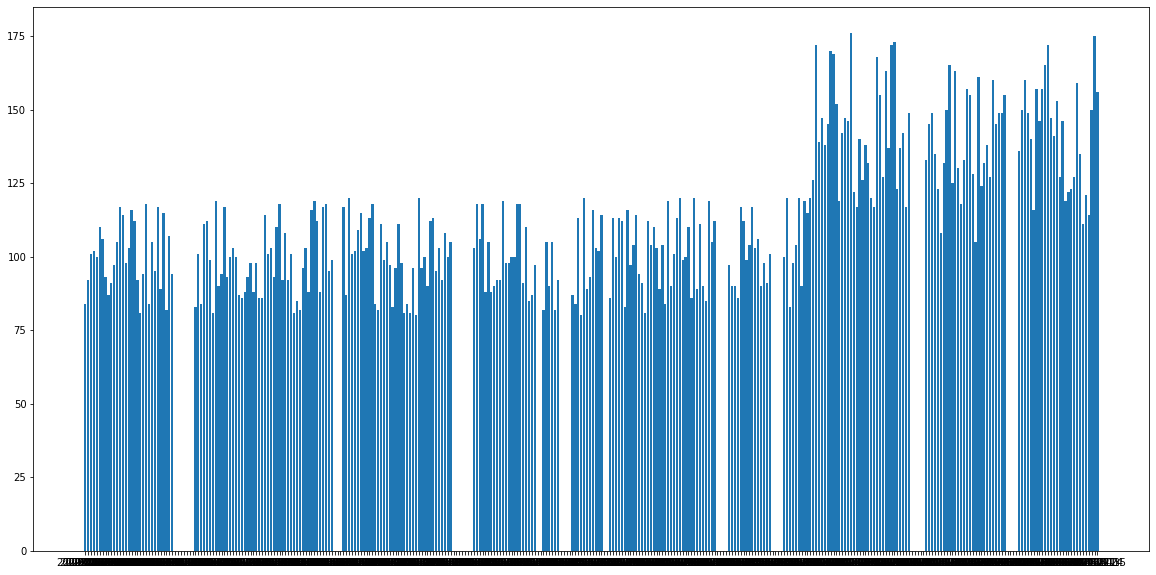

In [30]:
rows_added = pd.read_sql_query(SQL, conn)
rows_added = rows_added \
    .rename(columns={clmn: clmn.lower() for clmn in rows_added.columns})
rows_added = rows_added.set_index("date_added")
rows_added = rows_added.reindex(all_days)
plt.figure(figsize=(20, 10))
plt.bar(all_days, height=rows_added["rows_added"])
plt.show()

The row counts added seem to increase by ~1.5x each day starting around `DATE`. We could detect this using a threshold:

In [42]:
SQL = """
WITH ROW_COUNTS AS(
    SELECT
        DATE_ADDED,
        COUNT(*) AS ROWS_ADDED
    FROM
        HABITABLES
    GROUP BY
        DATE_ADDED
)
SELECT
    DATE_ADDED
FROM
    ROW_COUNTS
WHERE
    ROWS_ADDED > 150
"""

In [43]:
habitability_row_count_alerts = pd.read_sql_query(anoms_query, conn)
habitability_row_count_alerts = habitability_row_count_alerts \
    .rename(columns={clmn: clmn.lower() for clmn in habitability_row_count_alerts.columns})

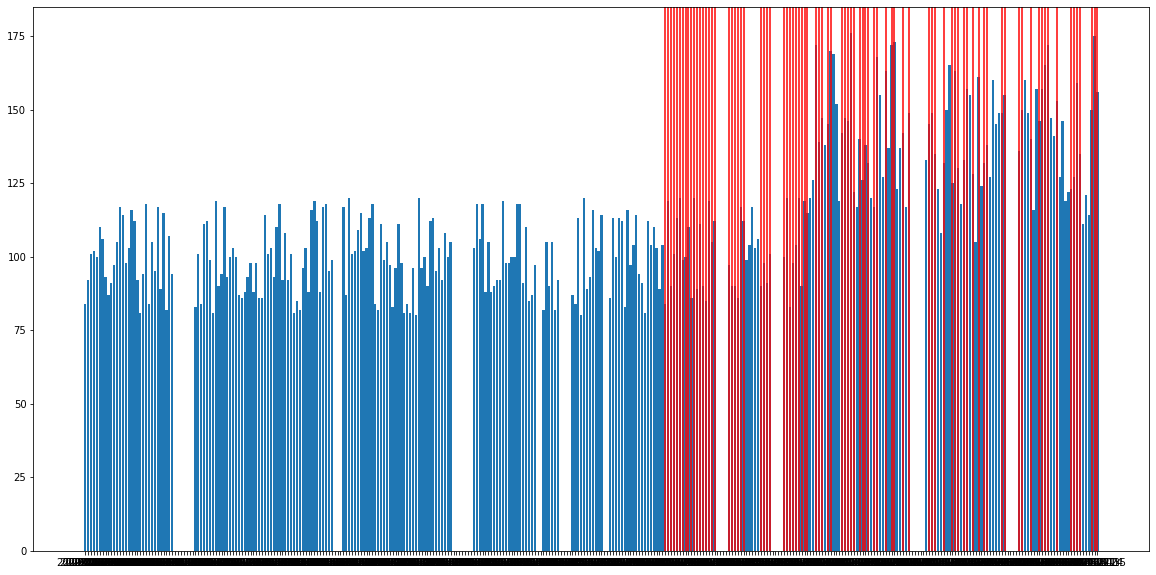

In [44]:
plt.figure(figsize=(20, 10))
plt.bar(all_days, height=rows_added["rows_added"])
for alert in habitability_row_count_alerts["date_added"]: plt.axvline(x = alert, color = 'r')
plt.show()

But again, that's not too informative. Something must be the cause of this volume change. As another exercise in understanding **distribution**, try querying for _uniqueness_ in `HABITABLES` to find a simultaneous issue.

- *Hint*: What's practically guaranteed to be unique in this table, if anything?

In [17]:
# TODO

# Great work!

This last exercise revealed that certain pillars of data observability are often conjoined to give meaningful alerts (volume and uniqueness; schema change and downstream distributions; etc.). In the next exercise, we'll look at some terms from machine learning to scale our approach.